# Preprocessing

In [ ]:
# # You may need to run those in your enviroment terminal.

%pip install -r requirements.txt

In [ ]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import spacy
import nltk
from nltk.corpus import wordnet
import random
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from datasets import Dataset
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score
import torch
import joblib


nltk.download('wordnet')
nltk.download('omw-1.4')

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

Creating data frame of the data and assigning them labels

In [212]:
texts = []
labels = []

base_path = Path('review_polarity/txt_sentoken')
pos_path = base_path / 'pos'
neg_path = base_path / 'neg'

# Assign label 1
if pos_path.exists():
    for file in pos_path.glob('*.txt'):
        with open(file, 'r', encoding = 'utf-8') as f:
            texts.append(f.read())
            labels.append(1)

# Assign label 0
if neg_path.exists():
    for file in neg_path.glob('*.txt'):
        with open(file, 'r', encoding = 'utf-8') as f:
            texts.append(f.read())
            labels.append(0)

df = pd.DataFrame({
    'label': labels,
    'text': texts
})

df.tail()

,label,text
1995,0,"if anything , "" stigmata "" should be taken as ..."
1996,0,"john boorman's "" zardoz "" is a goofy cinematic..."
1997,0,the kids in the hall are an acquired taste . \...
1998,0,there was a time when john carpenter was a gre...
1999,0,two party guys bob their heads to haddaway's d...


In [213]:
df[df.duplicated()]

,label,text


No duplicates were found

In [214]:
def spacy_pos_to_wordnet_pos(spacy_pos):
    if spacy_pos.startswith('N'):
        return wordnet.NOUN
    elif spacy_pos.startswith('V'):
        return wordnet.VERB
    elif spacy_pos.startswith('J'):
        return wordnet.ADJ
    elif spacy_pos.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default fallback

In [215]:
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    synonyms.discard(word)      # Remove the original word to avoid replacement with itself
    return list(synonyms)

In [216]:
def augment_text_with_synonyms(tokens, pos_tags, synonym_probability = 0.2):
    augmented_tokens = []

    for token, pos_tag in zip(tokens, pos_tags):
        if random.random() < synonym_probability:
            if pos_tag in ['n', 'v', 'a']:   #nouns adjectives and verbs
                synonyms = get_synonyms(token)
                if synonyms:
                    new_word = random.choice(synonyms)
                    augmented_tokens.append(new_word)
                    continue
        augmented_tokens.append(token)         # Add the original word if no augmentation is done

    return augmented_tokens

In [217]:
def apply_augmentation_to_dataset(word_tokens, pos_tags, texts, labels, sentence_tokens, synonym_probability = 0.2):
    all_word_tokens = word_tokens.copy()
    all_texts = texts.copy()  # Original text is preserved
    all_labels = labels.copy()
    all_sentence_tokens = sentence_tokens.copy()
    all_pos_tags = pos_tags.copy()

    for tokens, pos, label, sentence, text in zip(word_tokens, pos_tags, labels, sentence_tokens, texts):
        augmented_tokens = augment_text_with_synonyms(tokens, pos, synonym_probability)

        all_word_tokens.append(augmented_tokens)
        all_texts.append(text)  # Keep the original text
        all_labels.append(label)
        all_pos_tags.append(pos)
        all_sentence_tokens.append(sentence)  # Sentence tokens are not augmented

    return all_word_tokens, all_pos_tags, all_texts, all_labels, all_sentence_tokens

In [218]:
def apply_lemmatization(tokens):
    return [token.lemma_ for token in nlp(' '.join(tokens))]

In [219]:
def apply_stemming(text):

    words = text.split()
    return ' '.join([PorterStemmer().stem(word) for word in words])

In [220]:
def visualize_tf_idf_heatmap(tfidf_matrix, feature_names, n_top_features = 20, n_top_docs = 10):
    # Get the top features by summing TF-IDF scores across documents
    tfidf_array = tfidf_matrix.toarray()
    feature_importance = np.sum(tfidf_array, axis = 0)
    top_feature_indices = np.argsort(feature_importance)[-n_top_features:][::-1]
    top_features = [feature_names[i] for i in top_feature_indices]

    # Get the top documents by summing TF-IDF scores across features
    doc_importance = np.sum(tfidf_array, axis = 1)
    top_doc_indices = np.argsort(doc_importance)[-n_top_docs:][::-1]

    # Extract the submatrix for visualization
    sub_matrix = tfidf_array[np.ix_(top_doc_indices, top_feature_indices)]

    plt.figure(figsize = (12, 8))
    sns.heatmap(
        sub_matrix,
        annot = True,          # Show values in cells
        fmt = '.3f',           # Format with 3 decimal places
        cmap = 'YlGnBu',       # Better colormap
        xticklabels = top_features,
        yticklabels = range(n_top_docs)
    )
    plt.title(f'TF-IDF Heatmap (Top {n_top_features} Features, First {n_top_docs} Documents)')
    plt.xlabel('Words')
    plt.ylabel('Documents')
    plt.xticks(rotation = 45, ha = 'right')
    plt.tight_layout()
    plt.savefig("Visualization\\tfidf_heatmap.png")
    plt.close()

    # Bar chart of top features across the corpus
    plt.figure(figsize = (12, 6))
    top_features_scores = [feature_importance[i] for i in top_feature_indices]
    plt.bar(top_features, top_features_scores)
    plt.title('Top TF-IDF Features Across All Documents')
    plt.xlabel('Features')
    plt.ylabel('Sum of TF-IDF Scores')
    plt.xticks(rotation = 45, ha = 'right')
    plt.tight_layout()
    plt.savefig("Visualization\\tfidf_top_features.png")
    plt.close()

In [221]:
# --- Your existing code up to the train-test split ---
texts = df['text'].tolist()
labels = df['label'].tolist()
word_tokens = []
sentence_tokens = []
pos_tags = []

for text in texts:
    doc = nlp(text)
    sentence_tokens.append([sent.text.strip() for sent in doc.sents])
    tokens = [token for token in doc if not token.is_punct and not token.is_stop and not token.is_space]
    word_tokens.append([token.text.lower() for token in tokens])
    pos_tags.append([spacy_pos_to_wordnet_pos(token.tag_) for token in tokens])

lemmatized_tokens = [apply_lemmatization(t) for t in word_tokens]

word_tokens, pos_tags, texts, labels, sentence_tokens = apply_augmentation_to_dataset(
    lemmatized_tokens, pos_tags, texts, labels, sentence_tokens
)

joined_texts = [' '.join(tokens) for tokens in word_tokens]

augmented_df = pd.DataFrame({
    'label': labels,
    'text': joined_texts,
    'word_tokens': word_tokens
})

augmented_df = augmented_df.sample(frac=1, random_state=42).reset_index(drop=True)

train_texts, test_texts, train_labels, test_labels = train_test_split(
    augmented_df['text'], augmented_df['label'], test_size=0.2, random_state=42
)
# --- End of your existing code ---

# TF-IDF Vectorization
# 1. Create the vectorizer
vectorizer = TfidfVectorizer()

# 2. FIT ONLY on the training data
vectorizer.fit(train_texts)

# 3. TRANSFORM both training and testing data using the fitted vectorizer
xtrain_tfidf = vectorizer.transform(train_texts)
xtest_tfidf = vectorizer.transform(test_texts)

# --- Important: Do NOT fit the vectorizer again before transforming test data! ---

# If you need TF-IDF on the whole dataset for analysis or visualization (less common for model training)
# do it separately AFTER training and testing transforms
tfidf_matrix = vectorizer.transform(joined_texts)  # Use 'transform', not 'fit_transform'
feature_names = vectorizer.get_feature_names_out()

print(f"\nTF-IDF Matrix Shape (Train): {xtrain_tfidf.shape}")
print(f"TF-IDF Matrix Shape (Test): {xtest_tfidf.shape}")
print(f"TF-IDF Matrix Shape (Full): {tfidf_matrix.shape}")  # For analysis, not model training
print(f"Number of features: {len(feature_names)}")

visualize_tf_idf_heatmap(tfidf_matrix, feature_names)

# Save the vectorizer AFTER fitting on training data
filename = "Models\\Vectorizer.joblib"
joblib.dump(vectorizer, filename)


TF-IDF Matrix Shape (Train): (3200, 41197)
TF-IDF Matrix Shape (Test): (800, 41197)
TF-IDF Matrix Shape (Full): (4000, 41197)
Number of features: 41197


['Models\\Vectorizer.joblib']

In [222]:
print("augmented_df.head():")
display(augmented_df.head())

print("\ndf.head():")
display(df.head())

augmented_df.head():


,label,text,word_tokens
0,1,harmless silly fun comedy dim witte wrestle fa...,"[harmless, silly, fun, comedy, dim, witte, wre..."
1,0,spot motion-picture_show staging opera go comp...,"[spot, motion-picture_show, staging, opera, go..."
2,1,sick life death bob flanagan supermasochist fe...,"[sick, life, death, bob, flanagan, supermasoch..."
3,0,everybody photographic_film think alicia docum...,"[everybody, photographic_film, think, alicia, ..."
4,1,lisa cholodenko high art intelligent quiet dra...,"[lisa, cholodenko, high, art, intelligent, qui..."



df.head():


,label,text
0,1,films adapted from comic books have had plenty...
1,1,every now and then a movie comes along from a ...
2,1,you've got mail works alot better than it dese...
3,1,""" jaws "" is a rare film that grabs your atten..."
4,1,moviemaking is a lot like being the general ma...


In [223]:
print("augmented_df.tail():")
display(augmented_df.tail())

print("\ndf.tail():")
display(df.tail())

augmented_df.tail():


,label,text,word_tokens
3995,0,understand clich hell earth truly mean recentl...,"[understand, clich, hell, earth, truly, mean, ..."
3996,0,1954 japanese monster film godzilla transform ...,"[1954, japanese, monster, film, godzilla, tran..."
3997,1,verdict spine chilling drama horror maestro st...,"[verdict, spine, chilling, drama, horror, maes..."
3998,0,midway Eunectes_murinus documentary film_maker...,"[midway, Eunectes_murinus, documentary, film_m..."
3999,0,starship trooper bad movie mean bad movie cros...,"[starship, trooper, bad, movie, mean, bad, mov..."



df.tail():


,label,text
1995,0,"if anything , "" stigmata "" should be taken as ..."
1996,0,"john boorman's "" zardoz "" is a goofy cinematic..."
1997,0,the kids in the hall are an acquired taste . \...
1998,0,there was a time when john carpenter was a gre...
1999,0,two party guys bob their heads to haddaway's d...


In [224]:
print("\ndf info:")
display(df.info())

print("\naugmented_df info:")
display(augmented_df.info())


df info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   2000 non-null   int64 
 1   text    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None


augmented_df info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   label        4000 non-null   int64 
 1   text         4000 non-null   object
 2   word_tokens  4000 non-null   object
dtypes: int64(1), object(2)
memory usage: 93.9+ KB


None

In [225]:
print("\ndf dimentions:")
display(df.shape)

print("\naugmented_df dimentions:")
display(augmented_df.shape)


df dimentions:


(2000, 2)


augmented_df dimentions:


(4000, 3)

# Modelling - Classifiers

####        •    ML -> Logistic Regression, Naive Bayes, SVM, Decision tree, and Random Forest.

In [226]:
def train_model(classifier, feature_vector_train, train_labels, feature_vector_test, test_labels, is_neural_net=False):
    classifier.fit(feature_vector_train, train_labels)

    train_predictions = classifier.predict(feature_vector_train)
    test_predictions = classifier.predict(feature_vector_test)
    train_accuracy = metrics.accuracy_score(train_labels, train_predictions)
    test_accuracy = metrics.accuracy_score(test_labels, test_predictions)

    print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

    return test_accuracy  # Return the test accuracy

#### 1. Logistic Regression

In [227]:
model_l1 = linear_model.LogisticRegression(penalty='l1', C=0.7, solver='liblinear', random_state=42)
model_l1.fit(xtrain_tfidf, train_labels)

accuracy = train_model(model_l1, xtrain_tfidf, train_labels, xtest_tfidf, test_labels)

filename_l1 = r"Models\LR_L1.joblib"
joblib.dump(model_l1, filename_l1)

with open(r"Accuracies\LR_L1.txt", "w") as file:
    file.write(str(accuracy * 100))

Train Accuracy: 79.94%
Test Accuracy: 78.00%


In [228]:
model_l2 = linear_model.LogisticRegression(penalty='l2', C=0.7, solver='liblinear', random_state=42)
model_l2.fit(xtrain_tfidf, train_labels)

accuracy = train_model(model_l2, xtrain_tfidf, train_labels, xtest_tfidf, test_labels)

filename_l2 = r"Models\LR_L2.joblib"
joblib.dump(model_l2, filename_l2)

with open(r"Accuracies\LR_L2.txt", "w") as file:
    file.write(str(accuracy * 100))

Train Accuracy: 97.47%
Test Accuracy: 91.75%


#### 2. Naive Bayes

In [229]:
model = naive_bayes.MultinomialNB(alpha=0.7)
accuracy = train_model(model, xtrain_tfidf, train_labels, xtest_tfidf, test_labels)

filename = "Models\\NB.joblib"
joblib.dump(model, filename)

with open("Accuracies\\NB.txt", "w") as file:
    file.write(str(accuracy * 100))

Train Accuracy: 97.19%
Test Accuracy: 91.25%


#### 3. SVM

In [230]:
model = svm.SVC(kernel='linear', C=0.3)
accuracy = train_model(model, xtrain_tfidf, train_labels, xtest_tfidf, test_labels)

filename = "Models\\SVM_Linear.joblib"
joblib.dump(model, filename)

with open("Accuracies\\SVM_Linear.txt", "w") as file:
    file.write(str(accuracy * 100))

Train Accuracy: 96.22%
Test Accuracy: 91.25%


In [231]:
model = svm.SVC(kernel='rbf', C=0.3)
model.fit(xtrain_tfidf, train_labels)

accuracy = train_model(model, xtrain_tfidf, train_labels, xtest_tfidf, test_labels)

joblib.dump(model, r"Models\SVM_rbf.joblib")

with open(r"Accuracies\SVM_rbf.txt", "w") as file:
    file.write(str(accuracy * 100))

Train Accuracy: 98.41%
Test Accuracy: 91.75%


In [232]:
model = svm.SVC(kernel='poly', C=0.3, degree=4)
accuracy = train_model(model, xtrain_tfidf, train_labels, xtest_tfidf, test_labels)

filename = "Models\\SVM_Poly.joblib"
joblib.dump(model, filename)

with open("Accuracies\\SVM_Poly.txt", "w") as file:
    file.write(str(accuracy * 100))

Train Accuracy: 83.38%
Test Accuracy: 50.38%


#### 4. Decision Tree

In [233]:
model = DecisionTreeClassifier(max_depth=10, min_samples_split=5, min_samples_leaf=3, random_state=42)
accuracy = train_model(model, xtrain_tfidf, train_labels, xtest_tfidf, test_labels)

filename = "Models\\DT.joblib"
joblib.dump(model, filename)

with open("Accuracies\\DT.txt", "w") as file:
    file.write(str(accuracy * 100))

Train Accuracy: 84.50%
Test Accuracy: 74.88%


#### 5. Random Forest

In [234]:
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=42
)

accuracy = train_model(model, xtrain_tfidf, train_labels, xtest_tfidf, test_labels)

filename = "Models\\RF.joblib"
joblib.dump(model, filename)

with open("Accuracies\\RF.txt", "w") as file:
    file.write(str(accuracy * 100))

Train Accuracy: 96.03%
Test Accuracy: 87.12%


#### • DL -> BERT

In [235]:


# # Use same train/test split for BERT
# bert_train_texts = train_texts.tolist()
# bert_test_texts = test_texts.tolist()
# bert_train_labels = train_labels.tolist()
# bert_test_labels = test_labels.tolist()

# bert_train_ds = Dataset.from_dict({"text": bert_train_texts, "label": bert_train_labels})
# bert_test_ds = Dataset.from_dict({"text": bert_test_texts, "label": bert_test_labels})


In [236]:


# # Load the tokenizer
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# # Tokenize the datasets
# def tokenize_function(example):
#     return tokenizer(example["text"], padding="max_length", truncation=True, max_length=256)

# bert_train_ds = bert_train_ds.map(tokenize_function, batched=True)
# bert_test_ds = bert_test_ds.map(tokenize_function, batched=True)

# # Set PyTorch format
# bert_train_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
# bert_test_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])


In [237]:

# # Load pre-trained BERT for classification
# from transformers import DistilBertForSequenceClassification
# model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# # Define evaluation metric
# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = torch.argmax(torch.tensor(logits), dim=-1)
#     return {"accuracy": accuracy_score(labels, predictions)}


In [238]:
# training_args = TrainingArguments(
#     output_dir="./results",
#     evaluation_strategy="epoch",
#     save_strategy="no",
#     per_device_train_batch_size=4,
#     per_device_eval_batch_size=4,
#     num_train_epochs=2,
#     weight_decay=0.01,
#     logging_dir="./logs",
#     logging_steps=10,
# )

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=bert_train_ds,
#     eval_dataset=bert_test_ds,
#     compute_metrics=compute_metrics,
# )

# trainer.train()

In [239]:
# # Evaluate BERT model on test set
# metrics = trainer.evaluate()
# print(f"BERT Classification Accuracy: {metrics['eval_accuracy']:.4f}")


In [21]:
# save_dir = "Models/bert_sentiment_model"

# # Save model and tokenizer
# model.save_pretrained(save_dir)
# tokenizer.save_pretrained(save_dir)


('model/bert_sentiment_model\\tokenizer_config.json',
 'model/bert_sentiment_model\\special_tokens_map.json',
 'model/bert_sentiment_model\\vocab.txt',
 'model/bert_sentiment_model\\added_tokens.json')

227it [04:02,  1.07s/it]                          


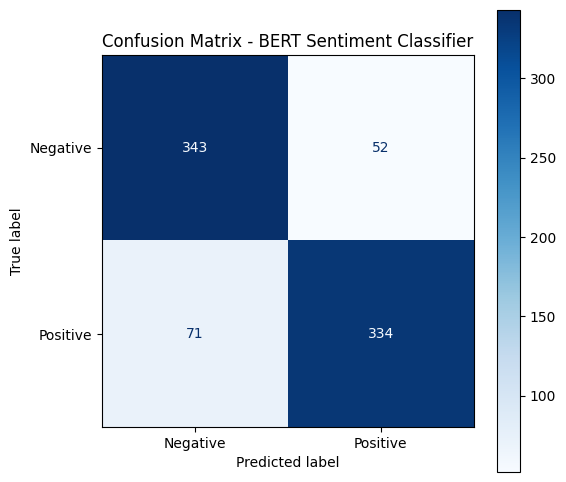

In [22]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt
# import torch

# # Run prediction on the test set
# pred_outputs = trainer.predict(bert_test_ds)

# # Get predicted and true labels
# pred_labels = torch.argmax(torch.tensor(pred_outputs.predictions), axis=1).numpy()
# true_labels = pred_outputs.label_ids

# # Define label names
# label_names = ["Negative", "Positive"]

# # Compute confusion matrix
# cm = confusion_matrix(true_labels, pred_labels)

# # Plot and save confusion matrix
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
# fig, ax = plt.subplots(figsize=(6, 6))
# disp.plot(cmap=plt.cm.Blues, ax=ax)
# plt.title("Confusion Matrix - BERT Sentiment Classifier")
# plt.savefig("bert_confusion_matrix.png")
# plt.show()
